In [1]:
from dask.optimization_compile import compiled
from dask.optimization_ast import compile_ast
import pickle
import dask
import dask.array as da
import numpy as np

def dummy(a):
    return a

def da_compiled(a):
    dsk = compiled(a.__dask_graph__(), a.__dask_keys__())
    return da.Array(dsk, a.name, a.chunks, a.dtype, a.shape)

def da_compile_ast(a):
    dsk = compile_ast(a.__dask_graph__(), a.__dask_keys__())
    return da.Array(dsk, a.name, a.chunks, a.dtype, a.shape)

def define(oz_func):
    a = da.arange(4, chunks=2)
    a = (a + 1) * (a - 1)
    # We're going to use this node as an input to
    # multiple ones; don't repeat calculations and
    # allow for parallelism. This is only a good idea if the
    # optimized calculation is expensive.
    a = oz_func(a)

    a = ((a < 2) - 10) * ((a > 2) + 10)
    # An input that can't be decompiled into AST
    a = a + np.array([7, 8, 9, 10])
    # We're reaching a reduction - we can add an optimization
    # point here to increase parallelism. This is only a good
    # idea if the computation is not trivial.
    a = oz_func(a)
    a = a.sum()
    # Final optimization
    a = oz_func(a)
    return a


da_std = define(dummy)
da_com = define(da_compiled)
da_ast = define(da_compile_ast)
da_std.compute(), da_com.compute(), da_ast.compute()

(-366, -366, -366)

In [2]:
print(len(pickle.dumps(da_std)))
print(len(pickle.dumps(da_com)))
print(len(pickle.dumps(da_ast)))
print(pickle.loads(pickle.dumps(da_com)).compute())
print(pickle.loads(pickle.dumps(da_ast)).compute())

2174
2243
2302
-366
-366


In [3]:
print("Vanilla dask")
print("============")
print("definition")
%timeit define(dummy)
print("compute")
%timeit da_std.compute(optimize_graph=False)
%timeit da_std.compute(optimize_graph=True)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_std))

print()
print("source compiled")
print("===============")
print("definition")
%timeit define(da_compiled)
print("compute")
%timeit da_com.compute(optimize_graph=False)
%timeit da_com.compute(optimize_graph=True)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_com))

print()
print("AST compiled")
print("============")
print("definition")
%timeit define(da_compile_ast)
print("compute")
%timeit da_ast.compute(optimize_graph=False)
%timeit da_ast.compute(optimize_graph=True)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_ast))

Vanilla dask
definition
2.23 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
compute
2.35 ms ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.59 ms ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
pickle->unpickle
76.4 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

source compiled
definition
3.37 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
compute
738 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
829 µs ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
267 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

AST compiled
definition
4.09 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
compute
765 µs ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
875 µs ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
86.6 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 100

In [4]:
for k, v in da_com.dask.items():
    print(k)
    print(v)
    print("-----------------------")
    print(v[0].source)
    print("=======================")    

('add-5276b14ff4d606ab6a1d07926d073b9c', 0)
(<CompiledFunction 7460442721402957794>, array([ 7,  8,  9, 10]), ('mul-31965abd6d7d3ec32210151a917a7489', 0))
-----------------------
import numpy


def _compiled(ndarray_0, dsk_mul_0):
    dsk_lt_0 = dsk_mul_0 < 2
    dsk_sub_0 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_0 > 2
    dsk_add_0 = dsk_gt_0 + 10
    dsk_mul_1 = dsk_sub_0 * dsk_add_0
    dsk_array_0 = numpy.asarray(ndarray_0[0:4])
    dsk_rechunk_0 = dsk_array_0[0:2]
    dsk_rechunk_1 = dsk_rechunk_0
    dsk_add_1 = dsk_mul_1 + dsk_rechunk_1
    return dsk_add_1

('add-5276b14ff4d606ab6a1d07926d073b9c', 1)
(<CompiledFunction 8761673637433336555>, array([ 7,  8,  9, 10]), ('mul-31965abd6d7d3ec32210151a917a7489', 1))
-----------------------
import numpy


def _compiled(ndarray_0, dsk_mul_0):
    dsk_lt_0 = dsk_mul_0 < 2
    dsk_sub_0 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_0 > 2
    dsk_add_0 = dsk_gt_0 + 10
    dsk_mul_1 = dsk_sub_0 * dsk_add_0
    dsk_array_0 = numpy.asarray(ndarray_0[0

In [5]:
# Don't discard the tree
with dask.config.set({'ast.debug': True}):
    da_ast = define(da_compile_ast)
    
for k, v in da_ast.dask.items():
    print(k)
    print(v)
    print("-----------------------")
    print(v[0].source)
    print("=======================")    

('add-5276b14ff4d606ab6a1d07926d073b9c', 0)
(<ASTFunction 8223082409647170463>, array([ 7,  8,  9, 10]), ('mul-31965abd6d7d3ec32210151a917a7489', 0))
-----------------------
import numpy


def _ast_compiled(ndarray_0, dsk_mul_0):
    dsk_lt_0 = dsk_mul_0 < 2
    dsk_sub_0 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_0 > 2
    dsk_add_0 = dsk_gt_0 + 10
    dsk_mul_1 = dsk_sub_0 * dsk_add_0
    dsk_array_0 = numpy.asarray(ndarray_0[slice(0, 4),])
    dsk_rechunk_0 = dsk_array_0[slice(0, 2),]
    dsk_add_1 = dsk_mul_1 + dsk_rechunk_0
    return dsk_add_1

('add-5276b14ff4d606ab6a1d07926d073b9c', 1)
(<ASTFunction -6384468101017765108>, array([ 7,  8,  9, 10]), ('mul-31965abd6d7d3ec32210151a917a7489', 1))
-----------------------
import numpy


def _ast_compiled(ndarray_0, dsk_mul_0):
    dsk_lt_0 = dsk_mul_0 < 2
    dsk_sub_0 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_0 > 2
    dsk_add_0 = dsk_gt_0 + 10
    dsk_mul_1 = dsk_sub_0 * dsk_add_0
    dsk_array_0 = numpy.asarray(ndarray_0[slice(0, 4),])
   

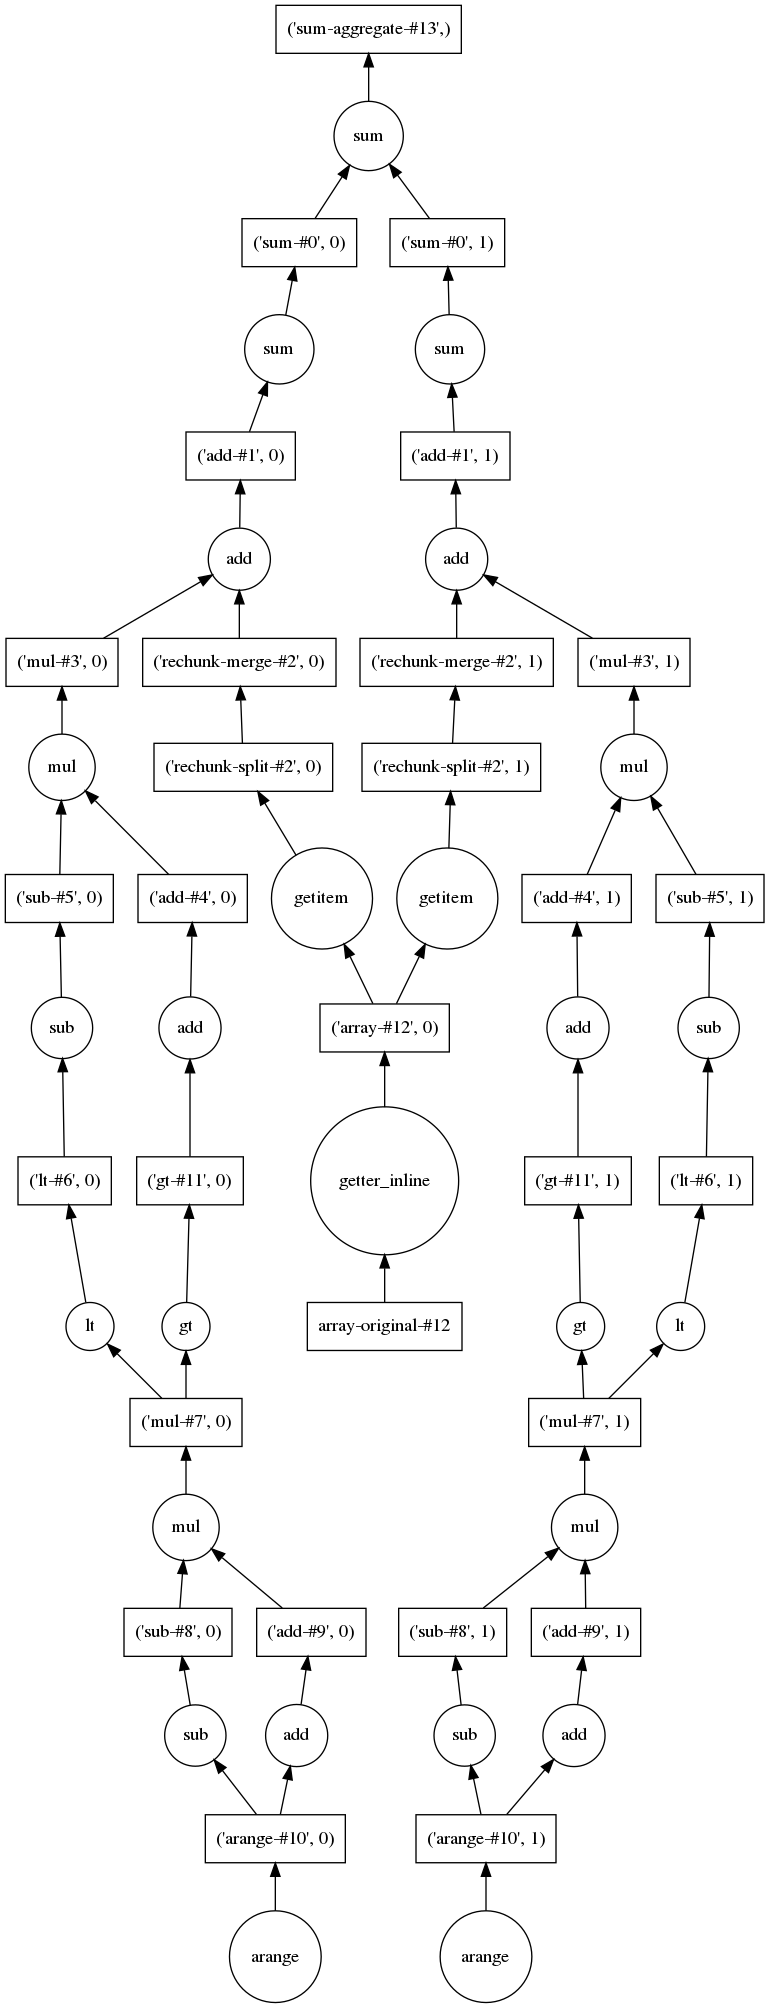

In [6]:
da_std.visualize()

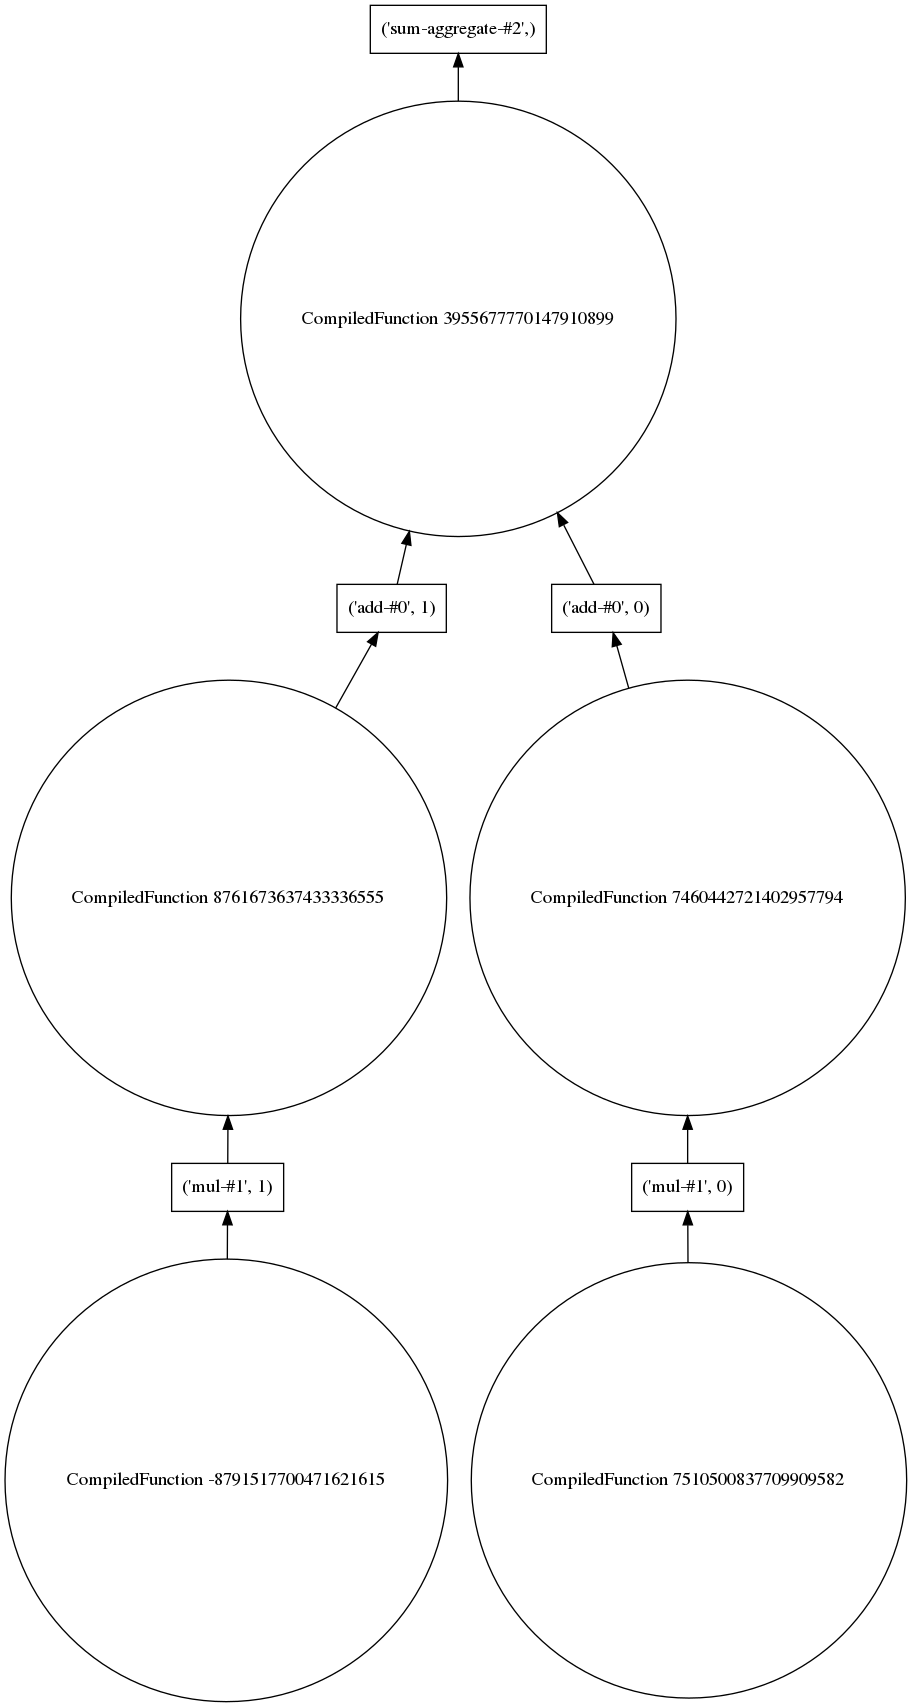

In [7]:
da_com.visualize()

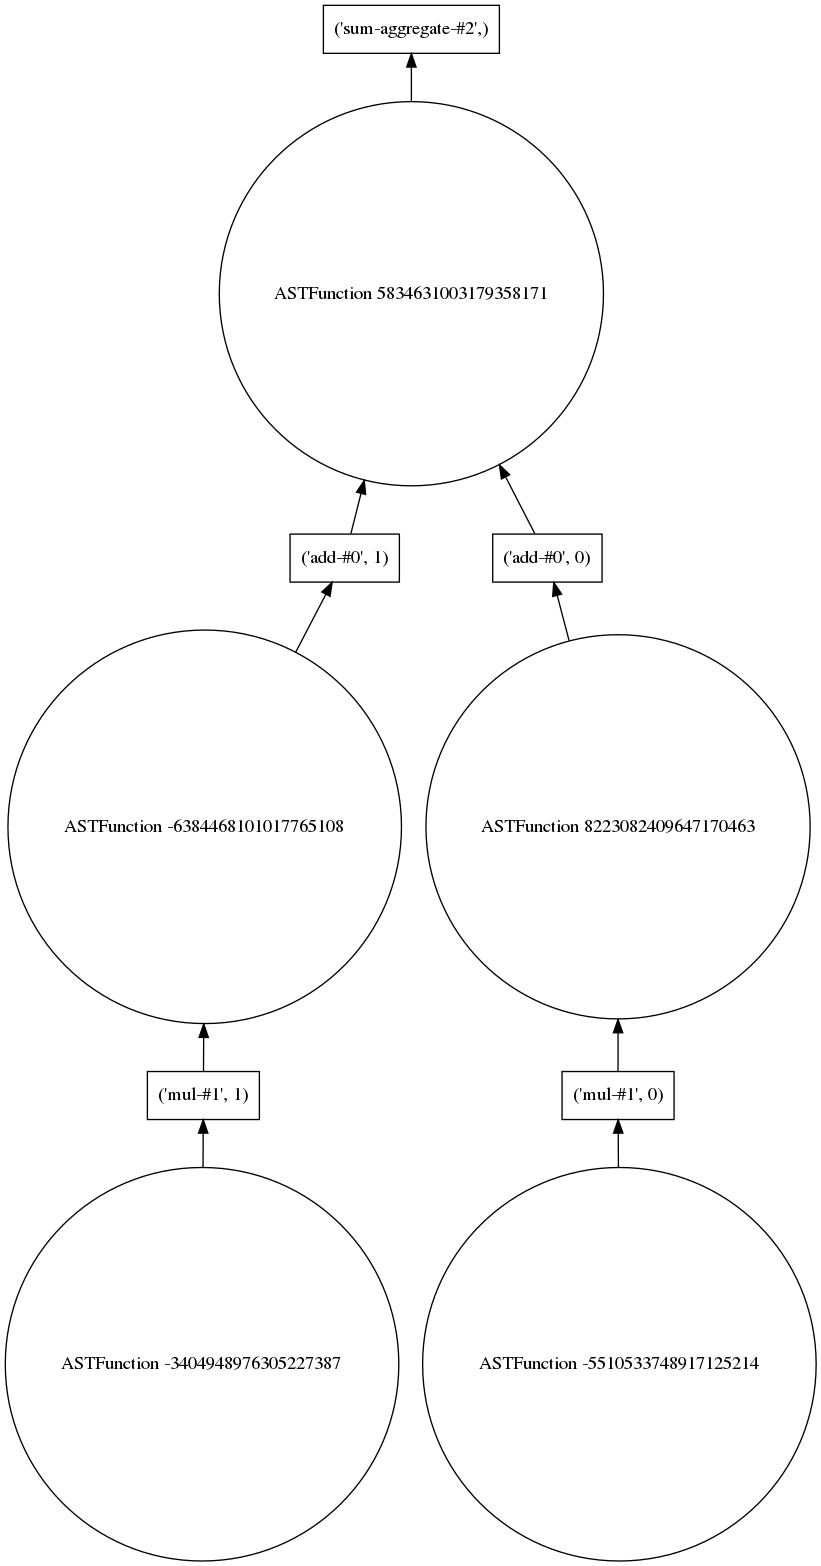

In [8]:
da_ast.visualize()